In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
%%time
df = pd.read_csv("../data/data_files.csv", encoding= 'unicode_escape') # read the data

CPU times: total: 46.9 ms
Wall time: 151 ms


# Exploratory Data Analysis (EDA)

### Step 1: Let' s take a look at the data

In [3]:
df.sample(5)

,URL,Name
71130,https://raw.githubusercontent.com/WordPress/Wo...,PHP
6449,https://raw.githubusercontent.com/django/djang...,PYTHON
19607,https://raw.githubusercontent.com/elastic/elas...,JAVA
36235,https://raw.githubusercontent.com/facebook/rea...,JAVASCRIPT
43280,https://raw.githubusercontent.com/nodejs/node/...,JAVASCRIPT


### Step 2: Number of Unique Values in all the columns

In [4]:
df.nunique()

URL     75124
Name        8
dtype: int64

In [5]:
df.describe()

,URL,Name
count,75124,75124
unique,75124,8
top,https://raw.githubusercontent.com/gap-system/g...,JAVA
freq,1,26768


### Step 3: Unique Values in 'Name Column' (Going to be made the target variable)

In [6]:
df['Name'].unique()

array(['GAP', 'PYTHON', 'JAVA', 'JAVASCRIPT', 'TYPESCRIPT', 'GO', 'PHP',
       'RUBY'], dtype=object)

### Step 4: Duplicate Check for "URL" column (as this column should only have unique urls)

In [7]:
df['URL'].duplicated().sum()

0

### Step 5: Check the info() on the features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75124 entries, 0 to 75123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URL     75124 non-null  object
 1   Name    75124 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


#### conclusion drawn from Step 5:
- both columns are of type 'object'

### Step 6: Check Class Distribution 

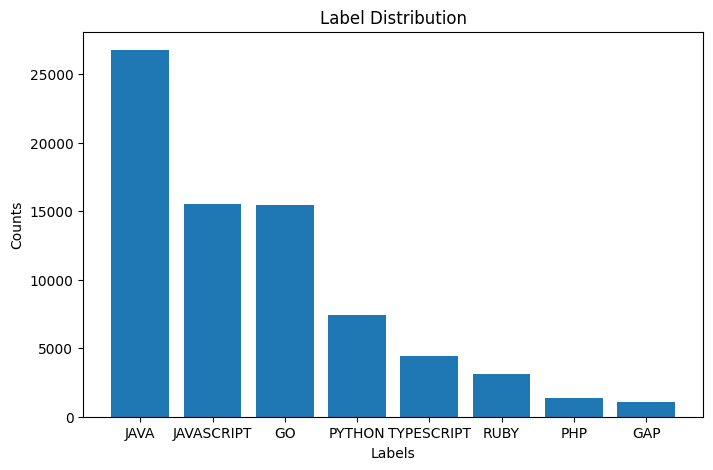

In [9]:
# Get the counts of unique labels within a column
label_counts = df['Name'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
# plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

In [10]:
df["Name"].value_counts()

Name
JAVA          26768
JAVASCRIPT    15526
GO            15458
PYTHON         7393
TYPESCRIPT     4408
RUBY           3138
PHP            1379
GAP            1054
Name: count, dtype: int64

# Function to reduce the dataset

In [11]:
def reduce_dataset(df):
    labels = df["Name"].unique()
    new_df = pd.DataFrame()
    
    length = df[df["Name"] == "GAP"].shape[0]
    
    for label in labels:
        new_df = pd.concat([new_df, df[df["Name"] == label].sample(length)], ignore_index=True)
    
    return new_df

In [12]:
reduced_df = reduce_dataset(df)

# Class Distribution after reducing the dataset

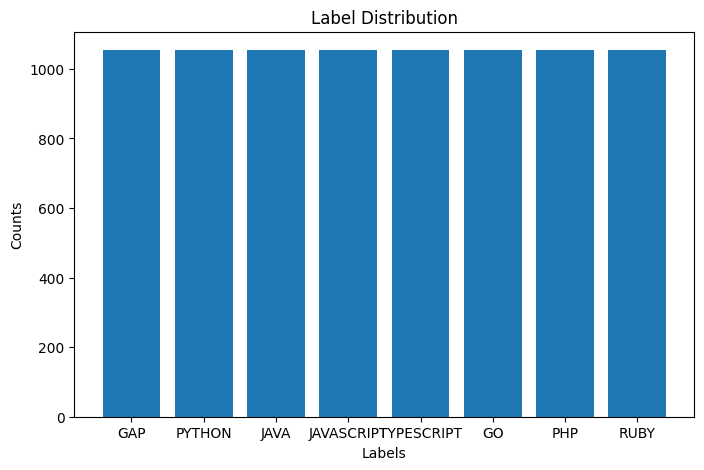

In [13]:
# Get the counts of unique labels within a column
label_counts = reduced_df['Name'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
# plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

In [14]:
reduced_df["Name"].value_counts()

Name
GAP           1054
PYTHON        1054
JAVA          1054
JAVASCRIPT    1054
TYPESCRIPT    1054
GO            1054
PHP           1054
RUBY          1054
Name: count, dtype: int64

# Function to remove non-ASCII characters from the given text

In [15]:
def remove_non_ascii(text):
    #Remove non-ASCII characters from the given text using a regular expression.
    cleaned_text = re.sub(r'[^\x00-\x7F]+', '', text)
    return cleaned_text

# Function to remove multiple spaces from the text

In [16]:
def remove_multiple_spaces(text):
    multiple_spaces_removed_text = " ".join(text.split()) 
    return multiple_spaces_removed_text

# Custom Transformer classes (So that sklearn's pipeline can be used)

In [17]:
import re
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
import chardet # an ML model, It uses machine learning to detect the encoding of a file

# Custom transformer for case-folding
class CaseFoldingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [x.lower() for x in X]

# Custom transformer for stop words removal
class StopWordsRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        stop_words_list = stopwords.words('english')
        return [' '.join([word for word in x.split() if word not in stop_words_list]) for x in X]
    
    # Custom transformer to remove numbers from text
class NumberRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Remove numbers using regular expression
        return [re.sub(r'\d+', '', text) for text in X]
    
class UrlToContentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for url in X:
            while True:
                try:    
                    response = requests.get(url)
                    content = response.content
                    encoding = chardet.detect(content)
        
                    if encoding['encoding'] == "ISO-8859-1":
                        decoded_content = content.decode("iso-8859-1")
                    elif encoding['encoding'] == "GB2312":
                        decoded_content = content.decode("GB2312")
                    else:
                        decoded_content = content.decode("utf-8")

                    # Remove non-ASCII characters from the decoded content
                    cleaned_content = remove_non_ascii(decoded_content)
                    mutliple_spaces_removed_content = remove_multiple_spaces(cleaned_content)
                    transformed_X.append(mutliple_spaces_removed_content)
                    break
                except Exception as e:
                    print(url)
                    decoded_content = content.decode("utf-8")
                    cleaned_content = remove_non_ascii(decoded_content)
                    mutliple_spaces_removed_content = remove_multiple_spaces(cleaned_content)
                    transformed_X.append(mutliple_spaces_removed_content)
                    break
        return transformed_X


# Create a Pipeline for the basic text pre-processing

In [18]:
from sklearn.pipeline import Pipeline

# Define the preprocessing steps
pipeline_preprocessing = Pipeline([
#     ('case_folding', CaseFoldingTransformer()),
#     ('stop_words_removal', StopWordsRemovalTransformer()),
    ('url_to_content', UrlToContentTransformer()),
    ('number_removal', NumberRemovalTransformer()),
])

#### Apply the preprocessing pipeline to the dataset

In [19]:
%%time
reduced_df['Content'] = pipeline_preprocessing.fit_transform(reduced_df['URL'])

CPU times: total: 1min 37s
Wall time: 39min 28s


#### Visualise the datset after the preprocessing pipeline

In [20]:
reduced_df['Content']

0       # GAP Implementation # $Id: homomorphisms.gi,v...
1       ##############################################...
2       ##############################################...
3       ##############################################...
4       ##############################################...
                              ...                        
8427    # frozen_string_literal: true require "isolati...
8428    # frozen_string_literal: true require "arel/vi...
8429    # frozen_string_literal: true require "cases/h...
8430    # frozen_string_literal: true require "cases/h...
8431    # frozen_string_literal: true require "active_...
Name: Content, Length: 8432, dtype: object

# Seperate the dataset into Independent and target variables

In [21]:
X = reduced_df['Content']
y = reduced_df['Name']

# Train-Test-Validation split

In [51]:
from sklearn.model_selection import train_test_split

# Split the data into training set (80%) and temporary set (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation set (10%) and final training set (90%)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42)

# NLP techniques

- #### Bag-of-Words (CountVectorizer)
- #### n-grams
- #### TF-IDF
- ##### Byte-Pair Encoding

In [23]:
# Bag-of-words can be implemented using "CountVectorizer" in sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tokenizers import ByteLevelBPETokenizer

#### Custom Transformer for  Byte-Pair Encoding

In [72]:
class BPEVectorizer:
    def __init__(self, vocab_size=3000): # default vocab_size is 30000 try with that too
        self.vocab_size = vocab_size
        self.tokenizer = ByteLevelBPETokenizer()

    def fit(self, X, y=None):
        texts = [text for text in X]
        self.tokenizer.train_from_iterator(texts, vocab_size=self.vocab_size, special_tokens=["<s>", "<pad>", "</s>", "<unk>"])
        return self

    def transform(self, X, max_length=1000):
        encoded_texts = [self.tokenizer.encode(text).ids for text in X]
        # Pad or truncate sequences to a fixed length of max_length
        padded_texts = [ids[:max_length] + [0] * (max_length - len(ids)) if len(ids) < max_length else ids[:max_length] for ids in encoded_texts]

        return np.array(padded_texts)


# Hyper-Parameter Tuning using GridSearchCV

#### Define a list of NLP techniques (vectorizers) with their hyperparameter grids

In [25]:
vectorizers = [
    (BPEVectorizer(), {}),
    
    (CountVectorizer(), {
        'vectorizer__max_features': [1000, 2000, 3000],
        'vectorizer__ngram_range': [(1, 1), (1, 2)]
    }),
    
    (TfidfVectorizer(), {
        'vectorizer__max_df': [0.8, 0.9, 1.0],
        'vectorizer__min_df': [1, 2, 3],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'vectorizer__use_idf': [True, False],
    }),
    
]

#### Define a list of classifiers with their hyperparameter grids

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

classifiers = [
    (LogisticRegression(), {'clf__C': [0.1, 1, 10], 'clf__max_iter': [500, 1000]}),
    (MultinomialNB(), {'clf__alpha': [0.1, 1, 10]}),
    (SVC(), {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}),
    (RandomForestClassifier(), {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 10, 20]})
]

In [38]:
# scoring = {
#     'accuracy': 'accuracy',          
#     'precision_macro': 'precision_macro',
#     'recall_macro': 'recall_macro',
#     'f1_macro': 'f1_macro'
# }

#### Perform GridSearchCV for hyperparameter tuning for all combinations

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

best_model = None
best_f1_score = 0

for vectorizer, vectorizer_params in vectorizers:
    for classifier, classifier_params in classifiers:
#         for metric_name, scoring_metric in scoring.items():
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('clf', classifier)
        ])

        param_grid = {**vectorizer_params, **classifier_params}

        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=make_scorer(f1_score, average='weighted'))
        grid_search.fit(X_train, y_train)

        score = grid_search.best_score_

        print(f"Vectorzier: {vectorizer.__class__.__name__}, Classifier: {classifier.__class__.__name__}")
        print("Best Hyperparameters:", grid_search.best_params_)
        print("Best F1-Score:", score)
        print()
        

        if score > best_f1_score:
            best_f1_score = score
            best_model = grid_search.best_estimator_


In [74]:
best_model

# Cross-Validation

In [75]:
# from sklearn.model_selection import cross_val_score

# # Specify the number of folds
# num_folds = 5

# accuracy_scores = cross_val_score(best_model, X, y, cv=num_folds, scoring='accuracy')
# print(np.mean(accuracy_scores))

# Evaluate the model

### Prection on test data

In [76]:
y_pred = best_model.predict(X_test)

AttributeError: 'NoneType' object has no attribute 'predict'

### Step 1: Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

### Step 2: Precision

In [ ]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='weighted')
print(precision)

### Step 3: Recall

In [ ]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='weighted')
print(recall)

### Step 4: F1-score

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

### Step 5: Classfication Report (Summary of steps 1-4)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

### Step 6: Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

#### Plot Confusion Matrix

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix')
plt.xticks(rotation=60)
plt.show()

### Step 7: ROC-Curve (Can be used if the labels become:- "GAP" & "Others")

In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score

# # Compute ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# auc = roc_auc_score(y_test, y_pred)

#### Plot ROC curve

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='b')
# plt.plot([0, 1], [0, 1], 'k--', color='gray', lw=2)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# Save the model

In [ ]:
import os

print(os.getcwd())
print(os.path.dirname(os.getcwd()))

In [ ]:
import pickle

# Full pipeline with preprocessing and classifier
full_pipeline = Pipeline([
    ('pipeline_preprocessing', pipeline_preprocessing),
    ('classifier_and_vectorizer', best_model)
])

# Save the full_pipeline object
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
os.makedirs(clf_folder_path, exist_ok=True)
clf_file_path = os.path.join(clf_folder_path, 'classifier2.pkl')

with open(clf_file_path, 'wb') as f:
    pickle.dump(full_pipeline, f)


# Load the saved model and see whether working or not

In [ ]:
import joblib

# Load the saved pipeline
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
clf_file_path = os.path.join(clf_folder_path, 'classifier2.pkl')
loaded_pipeline = joblib.load(clf_file_path)

# Use the loaded pipeline for predictions or other operations
predictions = loaded_pipeline.predict(['https://raw.githubusercontent.com/opencv/opencv/3aeaa3402389fc55e53fbc6f5741ca29f51032ee/modules/core/misc/java/src/java/core%2BMat.java'])

# Prediction

In [ ]:
predictions